# Plot XRD patterns in the d-spacing scale

- Please check [setup_for_notebooks](./setup_for_notebooks.ipynb) file if you have problem using the notebooks in this folder.

## Check the versio of pyFAI in your conda environment

In [1]:
import pyFAI
pyFAI.version

/Users/DanShim/anaconda/envs/peakpo7721/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'0.14.2'

Note that the example data files I provided are made with `pyFAI` version `0.14`.  If you see version higher than `0.15` here, you will get error when you read the example `dpp` file.  In that case, you either follow the instruction in [setup_for_notebooks.ipynb](./setup_for_notebooks.ipynb) or you may use your own dpp for this note book.

## Read dpp

In [2]:
import dill
import numpy as np

In [4]:
%ls ./data/*.dpp

./data/hSiO2_404_009.dpp


In [5]:
filen_dpp = './data/hSiO2_404_009.dpp'

In [6]:
with open(filen_dpp, 'rb') as f:
    model_dpp = dill.load(f)

## Setup a new PeakPo model and assign info from dpp

In [7]:
from model import PeakPoModel
model = PeakPoModel()

Make sure to reset the chi folder location using the `new_chi_path` option.

In [8]:
model.set_from(model_dpp, new_chi_path='./data/')

Please check `xrd_pattern.ipynb` file for some basic operations.

## Make a simple plot

In [9]:
def dsp2tth(dsp, wavelength):
    return np.rad2deg( np.arcsin( wavelength / (2. * dsp) ) ) * 2.

def tth2dsp(tth, wavelength):
    return 0.5 * wavelength / np.sin( np.deg2rad(tth/2.) )

In [10]:
def plot_diffpattern(ax_pattern, model, xrange=None, yrange=None, bgsub=True,
                    no_yticks=True, dsp_ticks=True, dsp_step = 0.2):
    """
    ax_pattern = axis of diffraction pattern
    model = PeakPo model
    
    """
    wavelength = model.base_ptn.wavelength
    ax_pattern.set_ylabel('Intensity (arbitrary unit)')

    if no_yticks:
        ax_pattern.set_yticks([])
    if bgsub:
        x_data, y_data = model.base_ptn.get_bgsub()
    else:
        x_data, y_data = model.base_ptn.get_raw()
        
    if dsp_ticks and (xrange is not None):
        xrange[0] = dsp2tth(xrange[0], wavelength)
        xrange[1] = dsp2tth(xrange[1], wavelength)        
    
    if xrange is None:
        xrange = [x_data.min(), x_data.max()]
    if yrange is None:
        yrange = [y_data.min(), y_data.max()]
    x = np.ma.masked_where( (x_data <= xrange[0]) | (x_data >= xrange[1]), x_data )
    y = np.ma.masked_where( (x_data <= xrange[0]) | (x_data >= xrange[1]), y_data )
    ax_pattern.set_xlim(xrange)    
    ax_pattern.set_ylim(yrange)        
    ax_pattern.plot(x, y, c='k', lw=1.0)

    #if xrange is not None:
    #    ax_pattern.set_xlim(x.min(),x.max())

    if dsp_ticks:
        ticks = np.arange( np.floor( (dsp2tth(x, wavelength)*10.).max())/10.,
                          np.ceil( (dsp2tth(x, wavelength)*10.).min())/10.,-dsp_step)
        ticks_in_tth = dsp2tth(ticks, wavelength)
        ax_pattern.set_xticks(ticks_in_tth)
        ax_pattern.set_xticklabels(np.around(ticks, decimals=1))
        ax_pattern.set_xlabel('d-spacing ($\mathdefault{\AA}$)')
    else:
        ax_pattern.set_xlabel('Two Theta (degrees)')

In [11]:
def plot_jcpds(ax_pattern, model, 
               in_cake=False,
               show_index=False, show_legend=False,
               bar_height=1., bar_position=0., bar_vsep=0.,
              phase_names=None):
    """
    bar position: position of the bar base in fraction.  negative number will shift 
        bars further down
    """
    selected_phases = []
    for phase in model.jcpds_lst:
        if phase.display:
            selected_phases.append(phase)
    if phase_names is not None:
        if len(phase_names) != len(selected_phases):
            return
    else:
        phase_names = []
        for phase in selected_phases:
            phase_names.append(phase.name) 
            
    n_displayed_jcpds = len(selected_phases)
    axisrange = ax_pattern.axis()
    #bar_scale = 1. / 100. * axisrange[3] * bar_factor / 100.
    pressure = model.get_saved_pressure()
    temperature = model.get_saved_temperature()
    wavelength =  model.base_ptn.wavelength
    for i, phase in enumerate(selected_phases):
        phase.cal_dsp(pressure, temperature)
        tth, inten = phase.get_tthVSint(wavelength)
        intensity = inten * phase.twk_int
        starting_intensity = np.ones_like(tth) * axisrange[2] - \
            bar_position * (axisrange[3] - axisrange[2])
        bar_max = starting_intensity - \
            (i*bar_vsep) * 100. * (bar_height) / n_displayed_jcpds
        bar_min = starting_intensity - \
            (i*bar_vsep+1) * 100. * (bar_height) / n_displayed_jcpds
        if pressure == 0.:
            volume = phase.v
        else:
            volume = phase.v.item()
        ax_pattern.vlines(
            tth, bar_min, bar_max, colors=phase.color,
            label=phase_names[i],
            lw=1.0,
            alpha=1.0)
        # hkl
        if show_index:
            hkl_list = phase.get_hkl_in_text()
            for j, hkl in enumerate(hkl_list):
                if tth[j] >= axisrange[0] and tth[j] <= axisrange[1]:
                    ax_pattern.text(
                        tth[j], bar_max[j], hkl.replace(" ", ""), color=phase.color,
                        rotation=90, verticalalignment='bottom',
                        horizontalalignment='center',
                        fontsize=8.,
                        alpha=1.0)
        ax_pattern.text(
            axisrange[0] + (axisrange[1] - axisrange[0])*0.01, 
            (bar_max[0] + bar_min[0])/2., phase_names[i],
            color=phase.color,
            verticalalignment='center',
            horizontalalignment='left',
            fontsize=8.,
            alpha=1.0)
    ymin = axisrange[2] - bar_position * (axisrange[3] - axisrange[2]) - \
        ( (n_displayed_jcpds-1) * bar_vsep + 1) * 100. * bar_height / n_displayed_jcpds
    ax_pattern.set_ylim((ymin, axisrange[3]))

    if show_legend:
        leg_jcpds = ax_pattern.legend(
            loc=0, prop={'size': 10}, framealpha=0., handlelength=1)
        for line, txt in zip(leg_jcpds.get_lines(), leg_jcpds.get_texts()):
            txt.set_color(line.get_color())

(5.808459294023262, 14.779176034451828, -10.0, 100.0)
(5.808459294023262, 14.779176034451828, -73.5, 100.0)


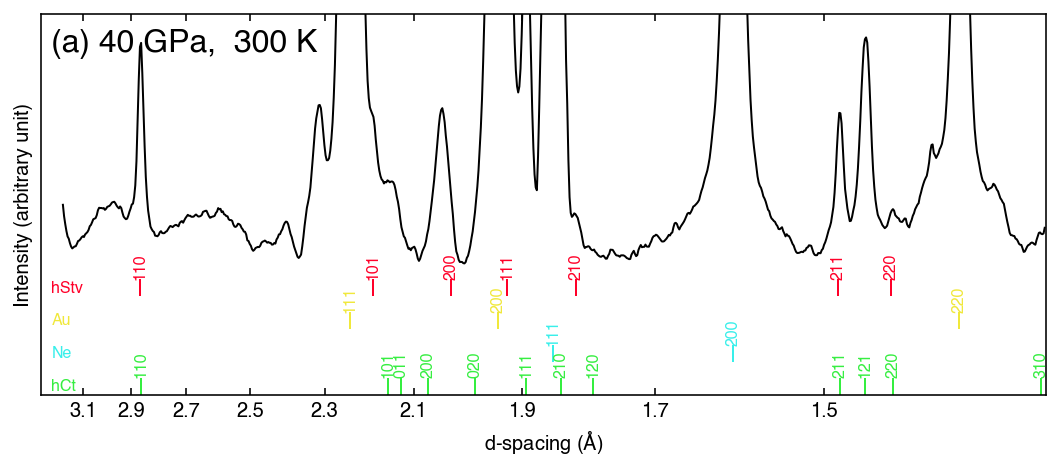

In [12]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

f, ax = plt.subplots(figsize=(9,3.5))
plot_diffpattern(ax, model, xrange=[3.3, 1.3], yrange=[-10.,100.])
print(ax.axis())
plot_jcpds(ax, model, bar_position=0.1, bar_height=0.3, 
           show_index=True, 
           phase_names = ['hStv', 'Au', 'Ne', 'hCt'], bar_vsep=2.)
print(ax.axis())
pressure = model.get_saved_pressure()
temperature = model.get_saved_temperature()
ax.text(0.01,0.9, "(a) {0:.0f} GPa, {1: .0f} K".format(pressure, temperature), 
        transform = ax.transAxes, fontsize=16)
plt.savefig('test.pdf', bbox_inches='tight')